In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg

# Load the datasets

In [ ]:
gdown

In [3]:
scrna = sc.read('../data/10xpbmc10k-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'cell_type'
    layers: 'count'

In [ ]:
gdown

In [5]:
scatac = sc.read('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type'
    layers: 'binary'

## Configure and train the model

In [6]:
model = mtg.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['RNA'], ['ATAC']],
    pair_groups=[[0], [0]],
    condition=False,
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2, # don't have here as 1 dataset
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [7]:
model.train(
    n_iters=10000,
    batch_size=256,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=3500,
    validate_every=1000,
    verbose=1
)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


 |████████████████████| 100.0% iter=10000/10000, time=18.71(s), loss=2.2551, recon=2.2546, kl=54.8728, integ=0.0000, cycle=0.0000, val_loss=2.2549, val_recon=2.2544, val_kl=49.9404, val_integ=0.0000, val_cycle=0.0000

### Plot training history

In [8]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,1000,2.317453,2.317413,20.608818,0.0,0.0,2.274158,2.274085,25.499208,0,0
1,2000,2.260331,2.260163,35.867129,0.0,0.0,2.267855,2.267635,38.369804,0,0
2,3000,2.309462,2.309096,48.951192,0.0,0.0,2.263189,2.262774,48.393593,0,0
3,4000,2.213560,2.213031,54.107864,0.0,0.0,2.259835,2.259336,49.897018,0,0
4,5000,2.253367,2.252794,57.244099,0.0,0.0,2.258070,2.257553,51.692867,0,0
5,6000,2.268474,2.267903,57.083865,0.0,0.0,2.256875,2.256358,51.753208,0,0
6,7000,2.254747,2.254176,57.006154,0.0,0.0,2.256150,2.255639,51.060677,0,0
7,8000,2.256834,2.256265,56.843100,0.0,0.0,2.255608,2.255099,50.911354,0,0
8,9000,2.261941,2.261381,56.024589,0.0,0.0,2.255463,2.254970,49.303322,0,0
9,9999,2.255104,2.254555,54.872836,0.0,0.0,2.254883,2.254383,49.940422,0,0


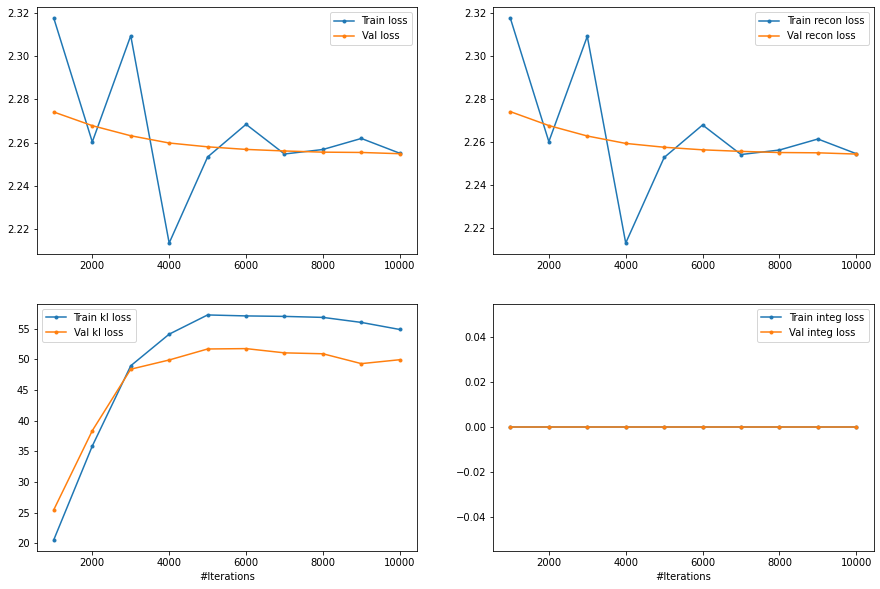

In [9]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Validation

### UMAP plot of the latent space

In [10]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['RNA'], ['ATAC']],
    pair_groups=[[0], [0]],
    batch_size=256
)
z

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 10000 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [11]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  ada

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'modality' as categorical
... storing 'cell_type' as categorical


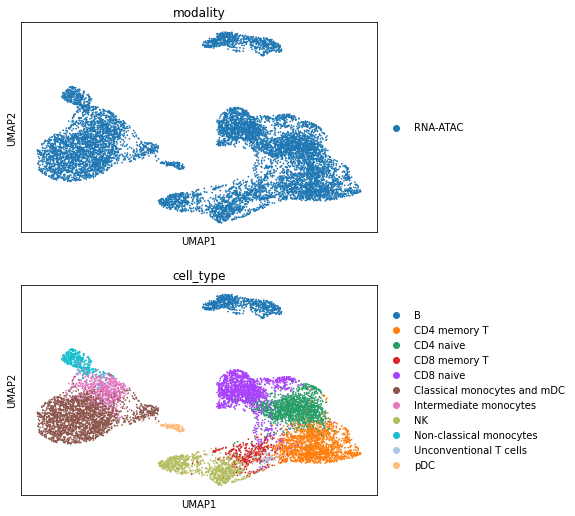

In [12]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

In [13]:
z.write('../data/integrated/multigrate/10xpbmc10k-multigrate.h5ad')